# Conditional GAN (cGAN)
The example here is for a more complex version that is tuned to generate images. It is known as Conditional Deep Convolutional GAN (cDCGAN)

### Step 1 - Import libraries

In [ ]:
# Tensorflow / Keras
from tensorflow import keras # for building Neural Networks
#print(keras.__version__) # print version
from keras.models import Model, load_model # for assembling a Neural Network model
from keras.layers import Input, Dense, Embedding, Reshape, Concatenate, Flatten, Dropout # for adding layers
from keras.layers import Conv2D, Conv2DTranspose, MaxPool2D, ReLU, LeakyReLU # for adding layers
from tensorflow.keras.utils import plot_model # for plotting model diagram
from tensorflow.keras.optimizers import Adam # for model optimization

# Dat manipulation
import numpy as np # for data manipulation
#print('numpy: %s' % np.__version__) # print version

# Visualization
import matplotlib
import matplotlib.pyplot as plt # for data visualizationa
print('matplotlib: %s' % matplotlib.__version__) # print version
import graphviz # for showing model diagram
print('graphviz: %s' % graphviz.__version__) # print version

# Other utilities
import sys
import os

# Assign main directory to a variable
main_dir=os.path.dirname(sys.path[0])
print(main_dir)

matplotlib: 3.7.1
graphviz: 0.20.3
/


### Step 2 - Load MNIST digit data

Shape of X_train:  (60000, 28, 28)
Shape of y_train:  (60000,)


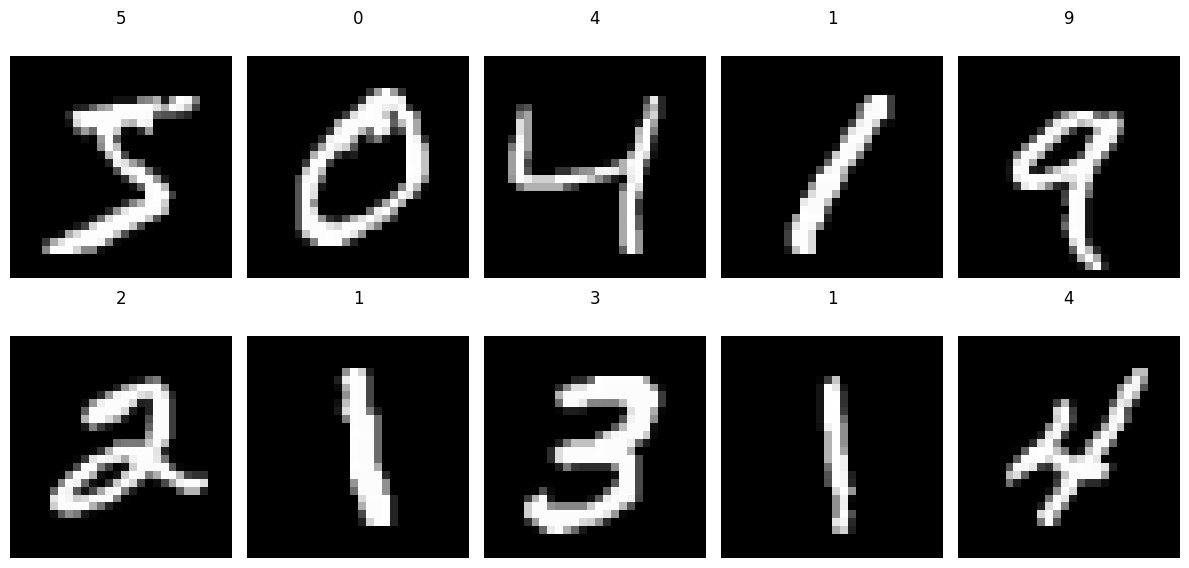

Shape of the scaled array:  (60000, 28, 28, 1)


In [ ]:
# Load digits data
(X_train, y_train), (_, _) = keras.datasets.mnist.load_data()

# Print shapes
print("Shape of X_train: ", X_train.shape)
print("Shape of y_train: ", y_train.shape)

# Display images of the first 10 digits in the training set and their true lables
fig, axs = plt.subplots(2, 5, sharey=False, tight_layout=True, figsize=(12,6), facecolor='white')
n=0
for i in range(0,2):
    for j in range(0,5):
        axs[i,j].matshow(X_train[n], cmap='gray')
        axs[i,j].set(title=y_train[n])
        axs[i,j].axis('off')
        n=n+1
plt.show()

# Scale and reshape as required by the model
data=X_train.copy()
data=data.reshape(X_train.shape[0], 28, 28, 1)
data = (data - 127.5) / 127.5  # Normalize the images to [-1, 1]
print("Shape of the scaled array: ", data.shape)

### Step 3 - Setup GAN

In [ ]:
def generator(latent_dim, in_shape=(7,7,1), n_cats=10):

    # Label Inputs
    in_label = Input(shape=(1,), name='Generator-Label-Input-Layer') # Input Layer
    lbls = Embedding(n_cats, 50, name='Generator-Label-Embedding-Layer')(in_label) # Embed label to vector

    # Scale up to image dimensions
    n_nodes = in_shape[0] * in_shape[1]
    lbls = Dense(n_nodes, name='Generator-Label-Dense-Layer')(lbls)
    lbls = Reshape((in_shape[0], in_shape[1], 1), name='Generator-Label-Reshape-Layer')(lbls) # New shape

    # Generator Inputs (latent vector)
    in_latent = Input(shape=(latent_dim,), name='Generator-Latent-Input-Layer')

    # Image Foundation
    n_nodes = 7 * 7 * 128 # number of nodes in the initial layer
    g = Dense(n_nodes, name='Generator-Foundation-Layer')(in_latent)
    g = ReLU(name='Generator-Foundation-Layer-Activation-1')(g)
    g = Reshape((in_shape[0], in_shape[1], 128), name='Generator-Foundation-Layer-Reshape-1')(g)

    # Combine both inputs so it has two channels
    concat = Concatenate(name='Generator-Combine-Layer')([g, lbls])

    # Hidden Layer 1
    g = Conv2DTranspose(filters=128, kernel_size=(4,4), strides=(2,2), padding='same', name='Generator-Hidden-Layer-1')(concat)
    g = ReLU(name='Generator-Hidden-Layer-Activation-1')(g)

    # Hidden Layer 2
    g = Conv2DTranspose(filters=128, kernel_size=(4,4), strides=(2,2), padding='same', name='Generator-Hidden-Layer-2')(g)
    g = ReLU(name='Generator-Hidden-Layer-Activation-2')(g)

    # Output Layer (Note, we use 1 filter since we have a greysclae image. Color image would have three
    output_layer = Conv2D(filters=1, kernel_size=(7,7), activation='tanh', padding='same', name='Generator-Output-Layer')(g)

    # Define model
    model = Model([in_latent, in_label], output_layer, name='Generator')
    return model

# Instantiate
latent_dim=100 # Our latent space has 100 dimensions. We can change it to any number
gen_model = generator(latent_dim)

# Show model summary and plot model diagram
gen_model.summary()
#plot_model(gen_model, show_shapes=True, show_layer_names=True, dpi=400, to_file=main_dir+'/pics/generator_structure.png')

Model: "Generator"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 Generator-Latent-Input-Lay  [(None, 100)]                0         []                            
 er (InputLayer)                                                                                  
                                                                                                  
 Generator-Label-Input-Laye  [(None, 1)]                  0         []                            
 r (InputLayer)                                                                                   
                                                                                                  
 Generator-Foundation-Layer  (None, 6272)                 633472    ['Generator-Latent-Input-Layer
  (Dense)                                                           [0][0]']              

In [ ]:
def discriminator(in_shape=(28,28,1), n_cats=10):

    # Label Inputs
    in_label = Input(shape=(1,), name='Discriminator-Label-Input-Layer') # Input Layer
    lbls = Embedding(n_cats, 50, name='Discriminator-Label-Embedding-Layer')(in_label) # Embed label to vector

    # Scale up to image dimensions
    n_nodes = in_shape[0] * in_shape[1]
    lbls = Dense(n_nodes, name='Discriminator-Label-Dense-Layer')(lbls)
    lbls = Reshape((in_shape[0], in_shape[1], 1), name='Discriminator-Label-Reshape-Layer')(lbls) # New shape

    # Image Inputs
    in_image = Input(shape=in_shape, name='Discriminator-Image-Input-Layer')

    # Combine both inputs so it has two channels
    concat = Concatenate(name='Discriminator-Combine-Layer')([in_image, lbls])

    # Hidden Layer 1
    h = Conv2D(filters=64, kernel_size=(3,3), strides=(2,2), padding='same', name='Discriminator-Hidden-Layer-1')(concat)
    h = LeakyReLU(alpha=0.2, name='Discriminator-Hidden-Layer-Activation-1')(h)

    # Hidden Layer 2
    h = Conv2D(filters=128, kernel_size=(3,3), strides=(2,2), padding='same', name='Discriminator-Hidden-Layer-2')(h)
    h = LeakyReLU(alpha=0.2, name='Discriminator-Hidden-Layer-Activation-2')(h)
    h = MaxPool2D(pool_size=(3,3), strides=(2,2), padding='valid', name='Discriminator-MaxPool-Layer-2')(h) # Max Pool

    # Flatten and Output Layers
    h = Flatten(name='Discriminator-Flatten-Layer')(h) # Flatten the shape
    h = Dropout(0.2, name='Discriminator-Flatten-Layer-Dropout')(h) # Randomly drop some connections for better generalization

    output_layer = Dense(1, activation='sigmoid', name='Discriminator-Output-Layer')(h) # Output Layer

    # Define model
    model = Model([in_image, in_label], output_layer, name='Discriminator')

    # Compile the model
    model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.0002, beta_1=0.5), metrics=['accuracy'])
    return model

# Instantiate
dis_model = discriminator()

# Show model summary and plot model diagram
dis_model.summary()
#plot_model(dis_model, show_shapes=True, show_layer_names=True, dpi=400, to_file=main_dir+'/pics/discriminator_structure.png')

Model: "Discriminator"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 Discriminator-Label-Input-  [(None, 1)]                  0         []                            
 Layer (InputLayer)                                                                               
                                                                                                  
 Discriminator-Label-Embedd  (None, 1, 50)                500       ['Discriminator-Label-Input-La
 ing-Layer (Embedding)                                              yer[0][0]']                   
                                                                                                  
 Discriminator-Label-Dense-  (None, 1, 784)               39984     ['Discriminator-Label-Embeddin
 Layer (Dense)                                                      g-Layer[0][0]']   

##### Combine Generator and Discriminator models into trainable GAN

In [ ]:
def def_gan(generator, discriminator):

    # We don't want to train the weights of discriminator at this stage. Hence, make it not trainable
    discriminator.trainable = False

    # Get Generator inputs / outputs
    gen_latent, gen_label = generator.input # Latent and label inputs from the generator
    gen_output = generator.output # Generator output image

    # Connect image and label from the generator to use as input into the discriminator
    gan_output = discriminator([gen_output, gen_label])

    # Define GAN model
    model = Model([gen_latent, gen_label], gan_output, name="cDCGAN")

    # Compile the model
    model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.0002, beta_1=0.5))
    return model

# Instantiate
gan_model = def_gan(gen_model, dis_model)

# Show model summary and plot model diagram
gan_model.summary()
#plot_model(gan_model, show_shapes=True, show_layer_names=True, dpi=400, to_file=main_dir+'/pics/dcgan_structure.png')

Model: "cDCGAN"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 Generator-Latent-Input-Lay  [(None, 100)]                0         []                            
 er (InputLayer)                                                                                  
                                                                                                  
 Generator-Label-Input-Laye  [(None, 1)]                  0         []                            
 r (InputLayer)                                                                                   
                                                                                                  
 Generator-Foundation-Layer  (None, 6272)                 633472    ['Generator-Latent-Input-Layer
  (Dense)                                                           [0][0]']                 

### Step 4 - Setup functions to:
- sample the latent space
- sample real images
- generate fake images with the generator model

##### Set up a function to sample real images

In [ ]:
def real_samples(dataset, categories, n):

    # Create a random list of indices
    indx = np.random.randint(0, dataset.shape[0], n)

    # Select real data samples (images and category labels) using the list of random indeces from above
    X, cat_labels = dataset[indx], categories[indx]

    # Class labels
    y = np.ones((n, 1))

    return [X, cat_labels], y
    #تستخدم للتمييو بين لاحقيقية والمزيفة

##### Generate points in the latent space, which we will use as inputs for the generator

In [ ]:
def latent_vector(latent_dim, n, n_cats=10):

    # Generate points in the latent space
    latent_input = np.random.randn(latent_dim * n)

    # Reshape into a batch of inputs for the network
    latent_input = latent_input.reshape(n, latent_dim)
#مدخلات للشبكة التوليدية
    # Generate category labels
    cat_labels = np.random.randint(0, n_cats, n)
#كل متجه يعني صورة بتاخد تسمية
    return [latent_input, cat_labels]
    #هيي مصفوفة فيها الصورة مع تسميتها



##### The below function will use the generator to generate n fake examples together with class labels

In [ ]:
def fake_samples(generator, latent_dim, n):

    # Generate points in latent space
    latent_output, cat_labels = latent_vector(latent_dim, n)

    # Predict outputs (i.e., generate fake samples)
    X = generator.predict([latent_output, cat_labels])

    # Create class labels
    y = np.zeros((n, 1))

    return [X, cat_labels], y

### Step 5 - Setup functions for model performance evaluation and training

##### Show a few fake (generated) images during trraining to get a sense of progress

In [ ]:
def show_fakes(generator, latent_dim, n=10):

    # Get fake (generated) samples
    x_fake, y_fake = fake_samples(generator, latent_dim, n)

    # Rescale from [-1, 1] to [0, 1]
    X_tst = (x_fake[0] + 1) / 2.0

    # Display fake (generated) images
    fig, axs = plt.subplots(2, 5, sharey=False, tight_layout=True, figsize=(12,6), facecolor='white')
    k=0
    for i in range(0,2):
        for j in range(0,5):
            axs[i,j].matshow(X_tst[k], cmap='gray')
            axs[i,j].set(title=x_fake[1][k])
            axs[i,j].axis('off')
            k=k+1
    plt.show()

##### Define a function to train our cDCGAN model (generator and discriminator)

In [ ]:
"""def train(g_model, d_model, gan_model, dataset, categories, latent_dim, n_epochs=10, n_batch=128, n_eval=200):
    # Number of batches to use per each epoch
    batch_per_epoch = int(dataset.shape[0] / n_batch)
    print(' batch_per_epoch: ',  batch_per_epoch)
    # Our batch to train the discriminator will consist of half real images and half fake (generated) images
    half_batch = int(n_batch / 2)

    # We will manually enumare epochs
    for i in range(n_epochs):

        # Enumerate batches over the training set
        for j in range(batch_per_epoch):

        # Discriminator training
            # Prep real samples
            [x_real, cat_labels_real], y_real = real_samples(dataset, categories, half_batch)
            #[x_real, cat_labels_real], y_real = generate_real_samples(dataset, half_batch)
            # Train discriminator with real samples
            discriminator_loss1, _ = d_model.train_on_batch([x_real, cat_labels_real], y_real)

            # Prep fake (generated) samples
            [x_fake, cat_labels_fake], y_fake = fake_samples(g_model, latent_dim, half_batch)
            # Train discriminator with fake samples
            discriminator_loss2, _ = d_model.train_on_batch([x_fake, cat_labels_fake], y_fake)


        # Generator training
            # Get values from the latent space to be used as inputs for the generator
            [latent_input, cat_labels] = latent_vector(latent_dim, n_batch)
            # While we are generating fake samples,
            # we want GAN generator model to create examples that resemble the real ones,
            # hence we want to pass labels corresponding to real samples, i.e. y=1, not 0.
            y_gan = np.ones((n_batch, 1))

            # Train the generator via a composite GAN model
            generator_loss = gan_model.train_on_batch([latent_input, cat_labels], y_gan)

        # Summarize training progress and loss
            if (j) % n_eval == 0:
                print('Epoch: %d, Batch: %d/%d, D_Loss_Real=%.3f, D_Loss_Fake=%.3f Gen_Loss=%.3f' %
                      (i+1, j+1, batch_per_epoch, discriminator_loss1, discriminator_loss2, generator_loss))
                show_fakes(g_model, latent_dim)"""



import matplotlib.pyplot as plt

def train(g_model, d_model, gan_model, dataset, categories, latent_dim, n_epochs=50, n_batch=128, n_eval=200):
    # Number of batches to use per each epoch
    batch_per_epoch = int(dataset.shape[0] / n_batch)
    print(' batch_per_epoch: ',  batch_per_epoch)
    # Our batch to train the discriminator will consist of half real images and half fake (generated) images
    half_batch = int(n_batch / 2)

    # Lists to store loss for each epoch
    d_loss_real_hist, d_loss_fake_hist, g_loss_hist = [], [], []

    # We will manually enumerate epochs
    for i in range(n_epochs):
        # Lists to store loss for each batch
        epoch_d_loss_real, epoch_d_loss_fake, epoch_g_loss = [], [], []

        # Enumerate batches over the training set
        for j in range(batch_per_epoch):

            # Discriminator training
            # Prep real samples
            [x_real, cat_labels_real], y_real = real_samples(dataset, categories, half_batch)
            # Train discriminator with real samples
            discriminator_loss1, _ = d_model.train_on_batch([x_real, cat_labels_real], y_real)
            epoch_d_loss_real.append(discriminator_loss1)

            # Prep fake (generated) samples
            [x_fake, cat_labels_fake], y_fake = fake_samples(g_model, latent_dim, half_batch)
            # Train discriminator with fake samples
            discriminator_loss2, _ = d_model.train_on_batch([x_fake, cat_labels_fake], y_fake)
            epoch_d_loss_fake.append(discriminator_loss2)

            # Generator training
            # Get values from the latent space to be used as inputs for the generator
            [latent_input, cat_labels] = latent_vector(latent_dim, n_batch)
            # While we are generating fake samples,
            # we want GAN generator model to create examples that resemble the real ones,
            # hence we want to pass labels corresponding to real samples, i.e. y=1, not 0.
            y_gan = np.ones((n_batch, 1))

            # Train the generator via a composite GAN model
            generator_loss = gan_model.train_on_batch([latent_input, cat_labels], y_gan)
            epoch_g_loss.append(generator_loss)

            # Summarize training progress and loss
            if (j+1) % n_eval == 0:
                print('Epoch: %d, Batch: %d/%d, D_Loss_Real=%.3f, D_Loss_Fake=%.3f Gen_Loss=%.3f' %
                      (i+1, j+1, batch_per_epoch, np.mean(epoch_d_loss_real), np.mean(epoch_d_loss_fake), np.mean(epoch_g_loss)))

        # Save average loss for the epoch
        d_loss_real_hist.append(np.mean(epoch_d_loss_real))
        d_loss_fake_hist.append(np.mean(epoch_d_loss_fake))
        g_loss_hist.append(np.mean(epoch_g_loss))

    # Plot loss
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, n_epochs + 1), d_loss_real_hist, label='D Loss Real')
    plt.plot(range(1, n_epochs + 1), d_loss_fake_hist, label='D Loss Fake')
    plt.plot(range(1, n_epochs + 1), g_loss_hist, label='G Loss')
    plt.title('Generator and Discriminator Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()




### Step 6 - Train the model and display some results

##### Use the above train function to train our cGAN model

Streaming output truncated to the last 5000 lines.
2/2 [==============================] - 0s 8ms/step
Epoch: 40, Batch: 200/468, D_Loss_Real=0.686, D_Loss_Fake=0.687 Gen_Loss=0.717
2/2 [==============================] - 0s 7ms/step
Epoch: 40, Batch: 400/468, D_Loss_Real=0.686, D_Loss_Fake=0.688 Gen_Loss=0.717
2/2 [==============================] - 0s 7ms/step
Epoch: 41, Batch: 200/468, D_Loss_Real=0.687, D_Loss_Fake=0.688 Gen_Loss=0.719
2/2 [==============================] - 0s 5ms/step
Epoch: 41, Batch: 400/468, D_Loss_Real=0.687, D_Loss_Fake=0.687 Gen_Loss=0.719
2/2 [==============================] - 0s 6ms/step
Epoch: 42, Batch: 200/468, D_Loss_Real=0.687, D_Loss_Fake=0.687 Gen_Loss=0.719
2/2 [==============================] - 0s 5ms/step
Epoch: 42, Batch: 400/468, D_Loss_Real=0.687, D_Loss_Fake=0.687 Gen_Loss=0.719
2/2 [==============================] - 0s 5ms/step
Epoch: 43, Batch: 200/468, D_Loss_Real=0.685, D_Loss_Fake=0.688 Gen_Loss=0.719
2/2 [==============================] - 

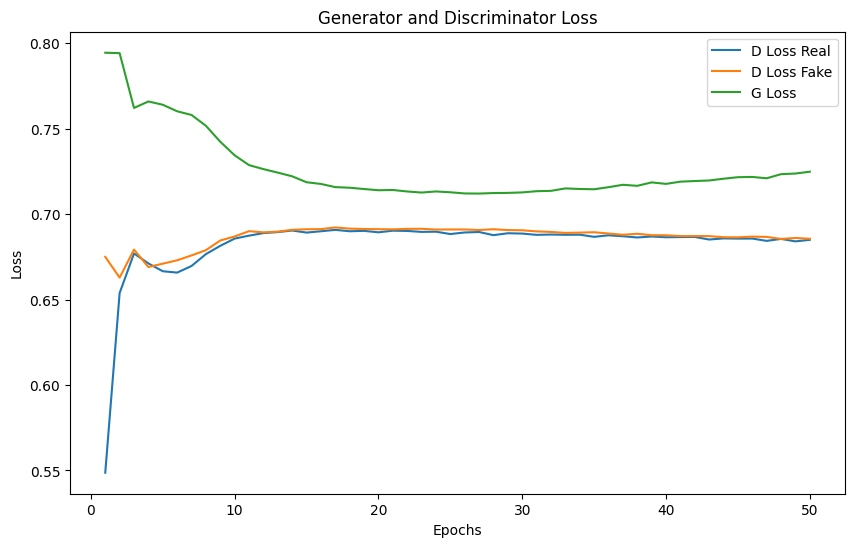

In [ ]:
# Train cDCGAN model for 10 epochs
train(gen_model, dis_model, gan_model, data, y_train, latent_dim)

### Step 7 - Save the model and use to it to generate images

##### Save the generator model

In [ ]:
# We need to compile the generator to avoid a warning. This is because we have previously only copiled within the larger cDCGAN model
gen_model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.0002, beta_1=0.5))
# Save the Generator on your drive
gen_model.save(main_dir+'/cgan_generator_a.h5')


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


##### Generate and display images

4/4 [==============================] - 1s 111ms/step


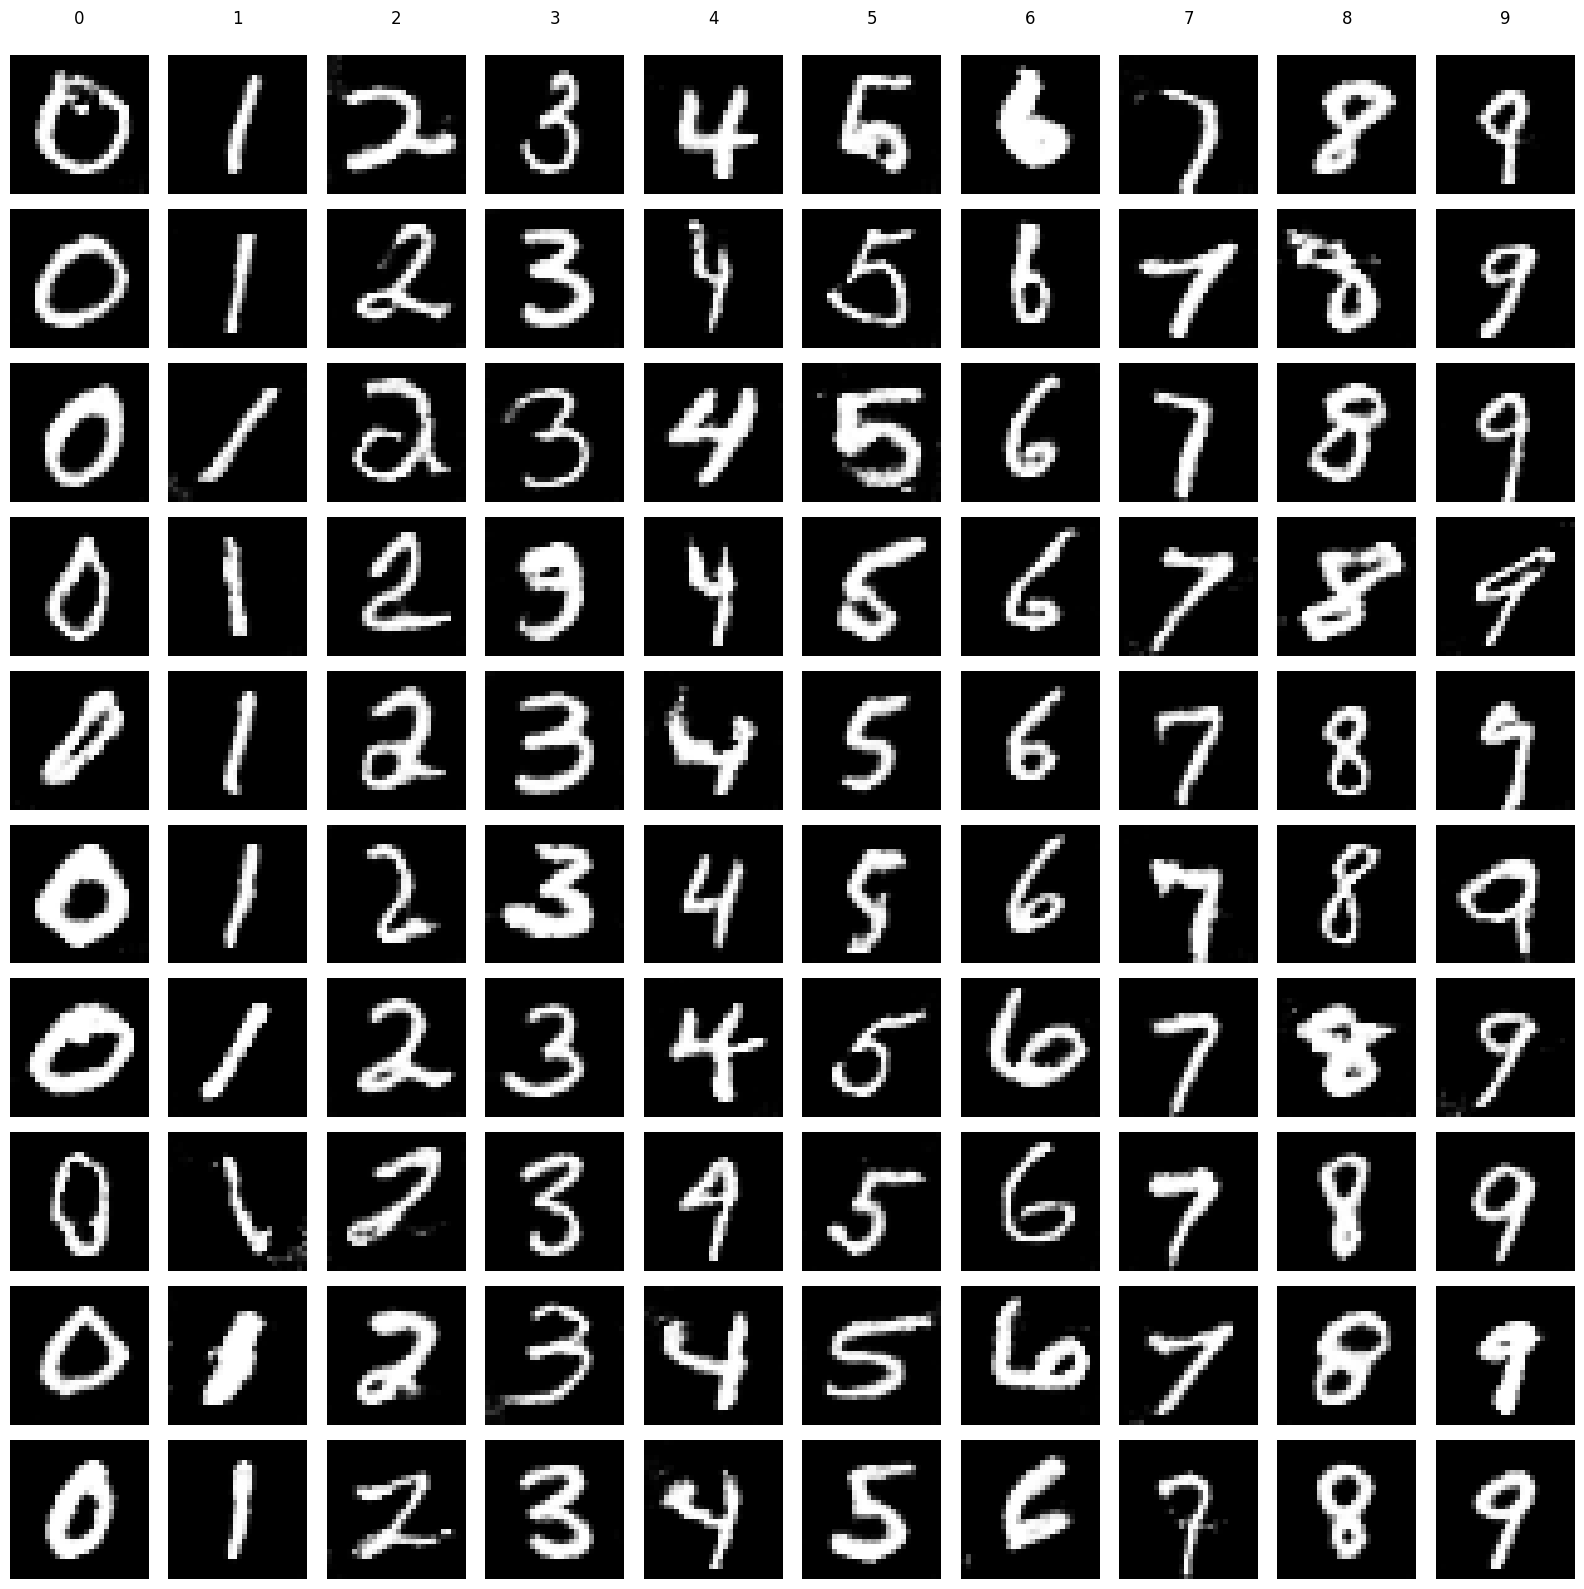

In [ ]:
# Generate latent points
latent_points, _ = latent_vector(100, 100)

# Specify labels that we want (0-9 repeated 10 times)
labels = np.asarray([x for _ in range(10) for x in range(10)])

# Load previously saved generator model
model = load_model(main_dir+'/cgan_generator_a.h5')

# Generate images
gen_imgs  = model.predict([latent_points, labels])

# Scale from [-1, 1] to [0, 1]
gen_imgs = (gen_imgs + 1) / 2.0

# Display images
fig, axs = plt.subplots(10, 10, sharey=False, tight_layout=True, figsize=(16,16), facecolor='white')
k=0
for i in range(0,10):
    for j in range(0,10):
        axs[i,j].matshow(gen_imgs[k], cmap='gray')
        axs[0,j].set(title=labels[k])
        axs[i,j].axis('off')
        k=k+1
plt.show()

# End of Program

In [ ]:
#model = load_model(main_dir+'/data/cgan_generator.h5')
import numpy as np
from keras.models import load_model
import matplotlib.pyplot as plt

def Print(label):

  def generate_image_by_label(generator, latent_dim, label):
      """
      Generate a single image for a given label using the trained generator.

      Parameters:
      - generator: Trained generator model
      - latent_dim: Dimension of the latent space
      - label: Label for which to generate the image (0 to 9)

      Returns:
      - Generated image
      """
      # Generate a point in the latent space
      latent_point = np.random.randn(1, latent_dim)

      # Create an array for the label
      label_array = np.array([label])

      # Generate the image
      gen_image = generator.predict([latent_point, label_array])

      # Rescale from [-1, 1] to [0, 1]
      gen_image = (gen_image + 1) / 2.0

      # Reshape to 28x28 if needed
      gen_image = gen_image.reshape(28, 28)

      return gen_image

  # Load the previously saved generator model
  generator_model = load_model(main_dir+'cgan_generator_a.h5')

  # Define the latent dimension
  latent_dim = 100

  # Generate and display an image for a given label
  # Example label (change to any number from 0 to 9)
  generated_image = generate_image_by_label(generator_model, latent_dim, label)

  # Display the generated image
  plt.imshow(generated_image, cmap='gray')
  plt.title(f'Generated Image for Label {label}')
  plt.axis('off')
  plt.show()


1/1 [==============================] - 0s 120ms/step


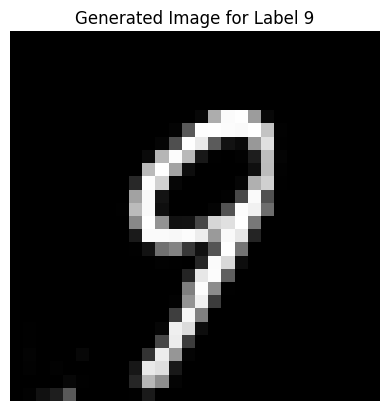

In [ ]:
Print(9)


1/1 [==============================] - 0s 298ms/step


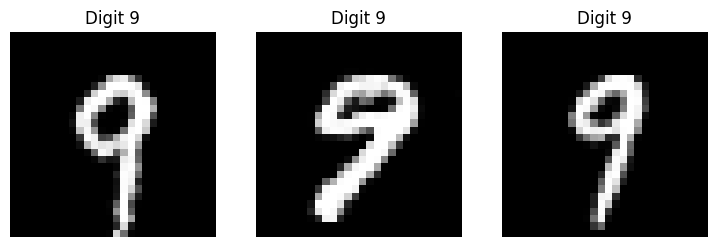

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from keras.models import load_model

# Function to generate images for given digits
def generate_digit_images(model, digits, latent_dim=100):
    # Ensure all digits are between 0 and 9
    for digit in digits:
        if digit < 0 or digit > 9:
            raise ValueError("All digits must be between 0 and 9")

    # Number of digits to generate
    n = len(digits)

    # Generate random points in the latent space
    latent_points = np.random.randn(n, latent_dim)

    # Create the label array for the specified digits
    labels = np.array(digits)

    # Use the model to generate images
    generated_images = model.predict([latent_points, labels])

    # Rescale the images from [-1, 1] to [0, 1]
    generated_images = (generated_images + 1) / 2.0

    # Plot the images
    fig, axs = plt.subplots(1, n, figsize=(n * 3, 3), facecolor='white')
    for i in range(n):
        axs[i].imshow(generated_images[i, :, :, 0], cmap='gray')
        axs[i].set(title=f'Digit {digits[i]}')
        axs[i].axis('off')
    plt.show()

# Load the pre-trained generator model
model_path = main_dir + 'cgan_generator_a.h5'
generator_model = load_model(model_path)

# Example usage: Generate images for digits 5, 4, and 6
generate_digit_images(generator_model, [9, 9, 9])
